In [19]:
import pandas as pd
import numpy as np
from numpy.random import seed # for reproducible results
seed(1)
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dense
from keras.regularizers import L1

In [4]:
target = 'infl_tp12'
DATA_FOLDER = '../Data/'
X = pd.read_csv(DATA_FOLDER + 'inflfc_features.csv', index_col='date')
ar_terms = pd.read_csv(DATA_FOLDER + 'ar_terms.csv',index_col='date')
y = pd.read_csv(DATA_FOLDER + 'inflfc_targets.csv',index_col='date')

X.index = pd.to_datetime(X.index)
ar_terms.index= pd.to_datetime(ar_terms.index)
X = pd.concat([X, ar_terms], axis=1)
y.index = pd.to_datetime(y.index)

# y = y.sum(axis=1)

y = y[target]
y

date
1960-02-01    0.000000
1960-03-01    0.000000
1960-04-01   -0.001006
1960-05-01    0.001006
1960-06-01    0.000000
                ...   
2020-08-01    0.003330
2020-09-01    0.004100
2020-10-01    0.008627
2020-11-01    0.006968
2020-12-01    0.005735
Name: infl_tp12, Length: 729, dtype: float64

<AxesSubplot: xlabel='date'>

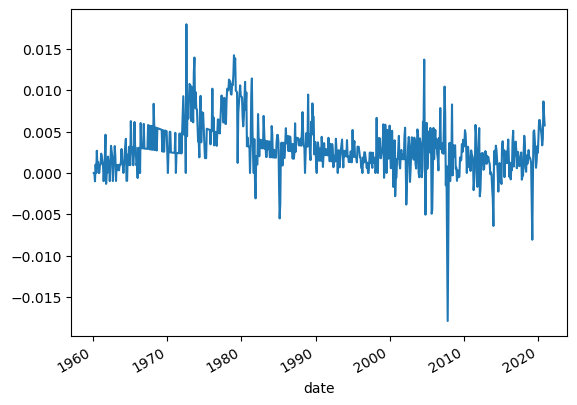

In [5]:
y.plot()

In [441]:
pd.DataFrame({'a':[1,2], 'b':[2, np.nan]})

,a,b
0,1,2.0
1,2,NaN


In [6]:
train_start = '1965-01-01'
train_end = '1984-12-01'
val_years = 5
val_start = datetime.strptime(train_end, '%Y-%m-%d') + relativedelta(months=1)
val_end = val_start + relativedelta(years=val_years-1, months=11)
test_start = val_end + relativedelta(months=1)
test_end = '2019-12-01'

print([train_start,train_end,val_start, val_end, test_start,test_end])



['1965-01-01', '1984-12-01', datetime.datetime(1985, 1, 1, 0, 0), datetime.datetime(1989, 12, 1, 0, 0), datetime.datetime(1990, 1, 1, 0, 0), '2019-12-01']


In [7]:
X_train = X.loc[train_start:train_end]
X_val = X.loc[val_start:val_end]
X_test = X.loc[test_start:test_end]

y_train = y.loc[train_start:train_end]
y_val = y.loc[val_start:val_end]
y_test = y.loc[test_start:test_end]

In [8]:
s = StandardScaler()
X_train = pd.DataFrame(s.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(s.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(s.transform(X_test),columns=X_test.columns, index=X_test.index)

In [28]:
def build_nn(architecture, input_shape, l1=0.0):
    
    
    """
    Builds a net according to specified architecture and activation function.
    
    Parameters 
    ----------
    architecture: an iterable containing the number of units in each layer. The length of the iterable determines the number of layers to add.
    activation: the activation function to use for each hidden_layer, 'elu' by default.
    
    Returns
    ----------
    model: a keras model object.
    """
    
    model = keras.models.Sequential()
    
    model.add(keras.Input(shape=input_shape))
    batch_standardize = False         
    
    n_layers = len(architecture)
    if n_layers >= 2:
        batch_standardize=True # for nets with two or more layers we apply batch normalization to avoid exploding/vanishing gradients
        
    layer=0
    for units in architecture:
        layer += 1
        model.add(keras.layers.Dense(units, 
                                     activation='relu',
                                     kernel_regularizer=keras.regularizers.l1(l1)
                                     ))
        if (batch_standardize) and (layer != len(architecture)):
            model.add(keras.layers.BatchNormalization())
        
            
    model.add(keras.layers.Dense(1, activation='linear'))
        
    # optimizer=keras.optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    return model

def build_lstm(architecture, dense_architecture, input_shape, recurrent_dropout=0.0, l1=0.0):

    # Init
    model = keras.models.Sequential()

    # Input layer
    model.add(keras.layers.Input(shape=input_shape, name='input'))
    
    for units in architecture[:-1]:
        model.add(
            LSTM(units, return_sequences=True, recurrent_dropout=recurrent_dropout,kernel_regularizer=L1(l1=l1))
        )

    # Do not return sequences for the last layer
    model.add(LSTM(architecture[-1], recurrent_dropout=recurrent_dropout,kernel_regularizer=L1(l1=l1)))

    if dense_architecture != None:
        for units in dense_architecture:
            model.add(Dense(units, activation='relu', kernel_regularizer=L1(l1=l1)))

    # Output layer
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    return model


In [12]:
def oos_r2_score(y_true, y_pred, y_train):

    mse = mean_squared_error(y_true, y_pred)
    mse_trainmean = mean_squared_error(y_true, np.full_like(y_true, np.mean(y_train)))
    r2 = 1 - mse/mse_trainmean

    return r2

def plot_training_and_validation_pred(model, trainX, valX, trainy, valy, train_preds=None, val_preds=None, use_preds=False):
    
    if use_preds == False:
        model_train_pred =  model.predict(trainX)
    else:
        model_train_pred = train_preds
        
    plt.plot(trainy.index,trainy, label='Actual')
    plt.plot(trainy.index, model_train_pred, label='Pred')
    plt.legend()
    plt.show()
    
    training_results = [mean_squared_error(trainy, model_train_pred, squared=False), mean_absolute_error(trainy, model_train_pred),
                       r2_score(trainy, model_train_pred)]
    
    training_results = [round(metric, 4) for metric in training_results]
    
    print(f'Training RMSE, MAE, and R2:{training_results}')
    
    if use_preds == False:
        model_val_pred =  model.predict(valX)
    else:
        model_val_pred = val_preds
    
    plt.plot(valy.index,valy, label='Actual')
    plt.plot(valy.index, model_val_pred,label='Pred')
    plt.legend()
    plt.show()
    
    validation_results = [mean_squared_error(valy, model_val_pred, squared=False), mean_absolute_error(valy, model_val_pred),
                         oos_r2_score(valy,model_val_pred,trainy)]
    
    validation_results = [round(metric, 4) for metric in validation_results]
    
    print(f'Validation RMSE, MAE, and OOS R2:{validation_results}')
    
    return None

In [11]:
cbs = [
    keras.callbacks.EarlyStopping(monitor='val_mae',min_delta=10**(-4), patience=20, restore_best_weights=True, verbose=1)
    # keras.callbacks.ReduceLROnPlateau(monitor='loss',min_delta=10**(-4), patience=5, restore_best_weights=True, verbose=1)
]

nn = build_nn(
    architecture=[32,16,8,4],
    input_shape = X_train.shape[1:],
    l1=0.1
)

hist = nn.fit(
    X_test, y_test,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=32,
    verbose=2
)

# pd.DataFrame(hist.history)[['loss','val_loss']].plot()

Epoch 1/1000
12/12 - 2s - loss: 53.3896 - mae: 0.7239 - val_loss: 49.9595 - val_mae: 0.2304 - 2s/epoch - 126ms/step
Epoch 2/1000
12/12 - 0s - loss: 48.8083 - mae: 0.6385 - val_loss: 45.7894 - val_mae: 0.1285 - 67ms/epoch - 6ms/step
Epoch 3/1000
12/12 - 0s - loss: 44.7300 - mae: 0.5652 - val_loss: 41.9596 - val_mae: 0.0846 - 62ms/epoch - 5ms/step
Epoch 4/1000
12/12 - 0s - loss: 40.7933 - mae: 0.4976 - val_loss: 38.2352 - val_mae: 0.0771 - 60ms/epoch - 5ms/step
Epoch 5/1000
12/12 - 0s - loss: 37.1310 - mae: 0.4872 - val_loss: 34.7412 - val_mae: 0.0818 - 63ms/epoch - 5ms/step
Epoch 6/1000
12/12 - 0s - loss: 33.6028 - mae: 0.4302 - val_loss: 31.4161 - val_mae: 0.0777 - 69ms/epoch - 6ms/step
Epoch 7/1000
12/12 - 0s - loss: 30.2894 - mae: 0.3796 - val_loss: 28.2430 - val_mae: 0.0741 - 63ms/epoch - 5ms/step
Epoch 8/1000
12/12 - 0s - loss: 27.1431 - mae: 0.3511 - val_loss: 25.2426 - val_mae: 0.0663 - 61ms/epoch - 5ms/step
Epoch 9/1000
12/12 - 0s - loss: 24.2015 - mae: 0.3321 - val_loss: 22.447

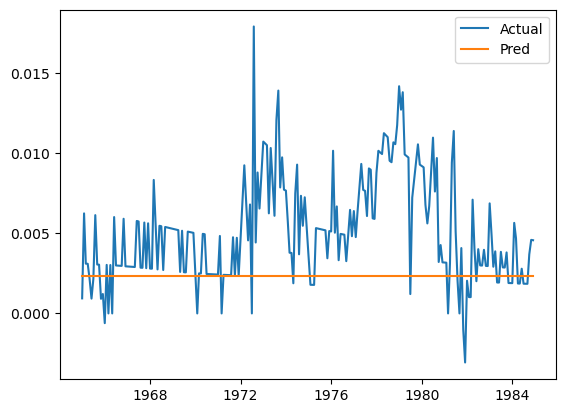

Training RMSE, MAE, and R2:[0.0043, 0.0032, -0.7468]


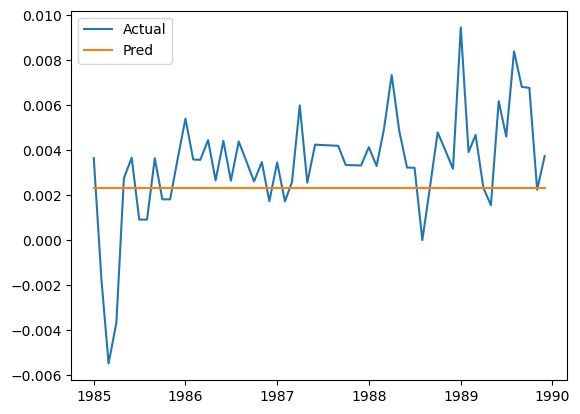

Validation RMSE, MAE, and OOS R2:[0.0026, 0.0019, 0.2275]


In [13]:
plot_training_and_validation_pred(nn, X_train, X_val, y_train, y_val)

Notes: 

LSTM 32 with dense 8-4 does quite well:  Training RMSE, MAE, and R2:[0.0012651761676542427, 0.001021687527684812, 0.8481440915906303]; Validation RMSE, MAE, and OOS R2:[0.0024497756493109136, 0.0016945872978912915, 0.3096719229822813]

Adding capacity (32-16d-8d) does worse: Training RMSE, MAE, and R2:[0.0005032848603014957, 0.00039074226145561667, 0.9759697979893952]; Validation RMSE, MAE, and OOS R2:[0.0025028240984251923, 0.0018855637128981802, 0.279450922808098]
- Implies overfitting

Reducing capacity: (32-8d) Does better than 32-8d-4d: Training RMSE, MAE, and R2:[0.0005014305428575605, 0.0004204152144350778, 0.9761465469357271]; Validation RMSE, MAE, and OOS R2:[0.0024291467102311023, 0.0016929487820934836, 0.32124912764465874]
- Lower MAE and RMSE and higher R2

Increasing capacity with fewer layers (32-16d) does significantly worse: Training RMSE, MAE, and R2:[0.0013728977527604545, 0.0009967374587089484, 0.8211841227967902]; Validation RMSE, MAE, and OOS R2:[0.0028894518358090794, 0.002139781518408194, 0.03964051577152039]

Reducing capacity (32-4d) Better than previous but not quite as good as (32-8d): Training RMSE, MAE, and R2:[0.00108319999448141, 0.0008383192869971229, 0.8886867180873936]; Validation RMSE, MAE, and OOS R2:[0.002533632532938633, 0.0019329297379325602, 0.26160259063708047]

Try (32-8d) with lower mindelta: Training RMSE, MAE, and R2:[0.0007470843159610693, 0.0005614605954661247, 0.9470496387524685]; Validation RMSE, MAE, and OOS R2:[0.002756567503465665, 0.001998126118472479, 0.1259421561326861]
- Not as good
- After second attempt to see if this was just a bad random init the results were also worse.

Noticed adding LSTM layers improves training. 32-16-8d was pretty good, 32-32-8d acheived 0.33 oos R2, the highest so far.


In [14]:
X_train_lstm, X_val_lstm, X_test_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1]),X_val.values.reshape(X_val.shape[0], 1, X_val.shape[1]),X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])
input_shape = X_train_lstm.shape[1:]

In [40]:
cbs = [
    keras.callbacks.EarlyStopping(monitor='val_mae',min_delta=10**(-4), patience=50, restore_best_weights=True, verbose=1)
]

lstm2 = build_lstm(
    architecture=[32,32],
    dense_architecture=[16,8],
    input_shape=input_shape,
    recurrent_dropout=0.2,
    l1=0.1
)

lstm2.fit(X_train_lstm, y_train,
          validation_data=(X_val_lstm, y_val),
          epochs=1500,
          batch_size=32,
          verbose=2,
          callbacks=cbs
)

Epoch 1/1500
8/8 - 5s - loss: 176.3569 - mae: 0.0059 - val_loss: 166.3229 - val_mae: 0.0037 - 5s/epoch - 682ms/step
Epoch 2/1500
8/8 - 0s - loss: 159.6409 - mae: 0.0037 - val_loss: 150.1349 - val_mae: 0.0025 - 71ms/epoch - 9ms/step
Epoch 3/1500
8/8 - 0s - loss: 143.8132 - mae: 0.0027 - val_loss: 134.8337 - val_mae: 0.0024 - 75ms/epoch - 9ms/step
Epoch 4/1500
8/8 - 0s - loss: 128.8408 - mae: 0.0026 - val_loss: 120.3339 - val_mae: 0.0020 - 72ms/epoch - 9ms/step
Epoch 5/1500
8/8 - 0s - loss: 114.6966 - mae: 0.0025 - val_loss: 106.7138 - val_mae: 0.0021 - 72ms/epoch - 9ms/step
Epoch 6/1500
8/8 - 0s - loss: 101.4357 - mae: 0.0026 - val_loss: 93.9400 - val_mae: 0.0023 - 75ms/epoch - 9ms/step
Epoch 7/1500
8/8 - 0s - loss: 89.0059 - mae: 0.0025 - val_loss: 82.0483 - val_mae: 0.0021 - 74ms/epoch - 9ms/step
Epoch 8/1500
8/8 - 0s - loss: 77.4779 - mae: 0.0025 - val_loss: 71.0096 - val_mae: 0.0022 - 74ms/epoch - 9ms/step
Epoch 9/1500
8/8 - 0s - loss: 66.7660 - mae: 0.0025 - val_loss: 60.8117 - val

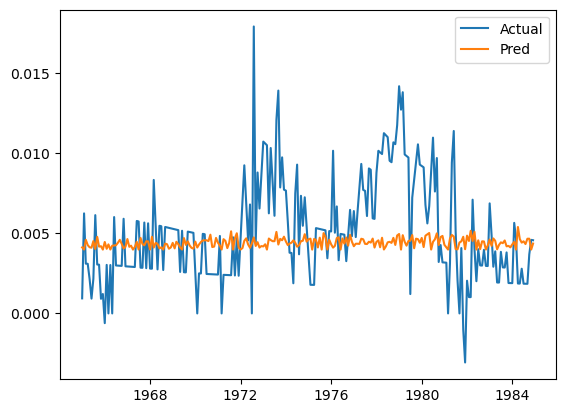

Training RMSE, MAE, and R2:[0.0033, 0.0026, -0.0325]


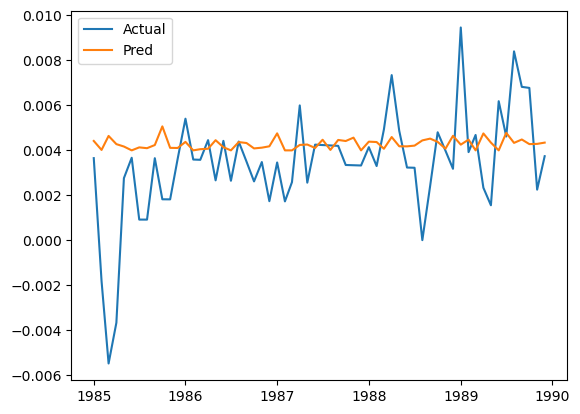

Validation RMSE, MAE, and OOS R2:[0.0026, 0.0017, 0.2519]


In [42]:
plot_training_and_validation_pred(lstm2, X_train_lstm, X_val_lstm, y_train, y_val)

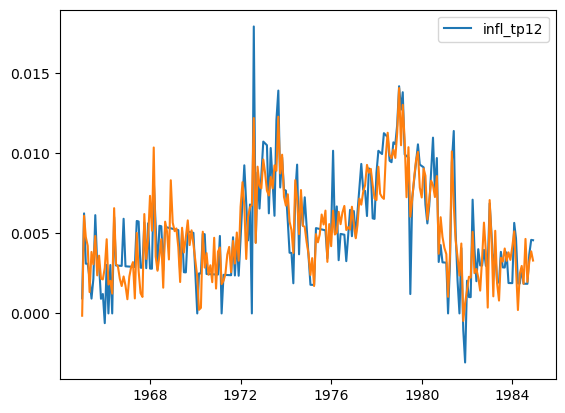

Training RMSE, MAE, and R2:[0.001637720258813525, 0.0012366714090341448, 0.7455460881392779]


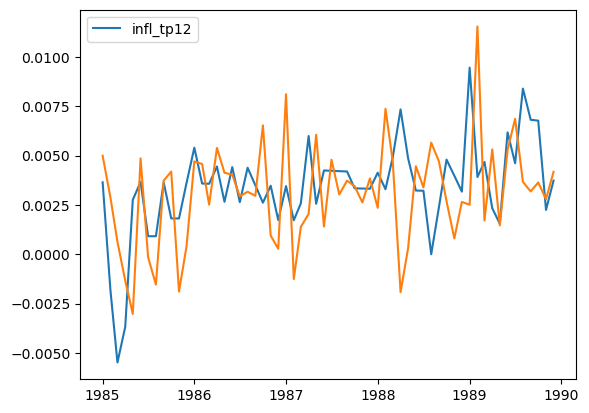

Validation RMSE, MAE, and OOS R2:[0.0031524420442706376, 0.0023965396725871098, -0.14313397510251713]


In [32]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

plot_training_and_validation_pred(lr, X_train, X_val, y_train, y_val)

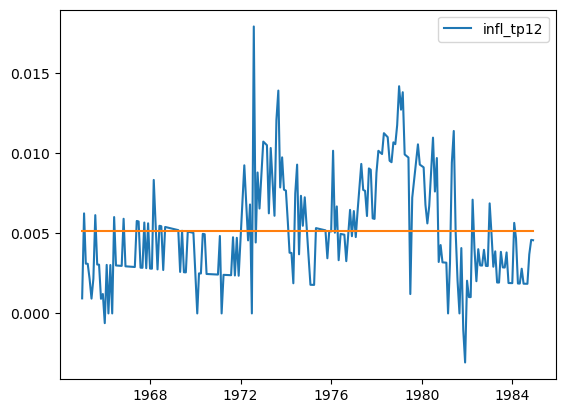

Training RMSE, MAE, and R2:[0.0032466476277253444, 0.0025595302161776907, 0.0]


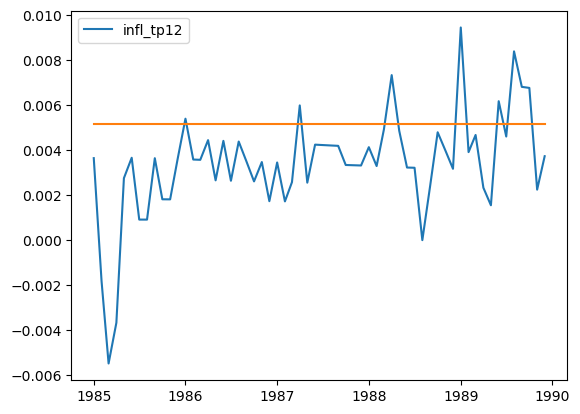

Validation RMSE, MAE, and OOS R2:[0.0029484824341349182, 0.002261222141483692, 0.0]


In [34]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=10.0, random_state=1).fit(X_train, y_train)

plot_training_and_validation_pred(lasso, X_train, X_val, y_train, y_val)

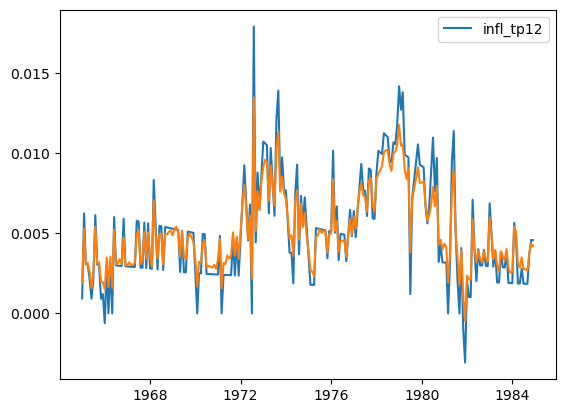

Training RMSE, MAE, and R2:[0.0009809575841141615, 0.0007359241828346682, 0.908708541058052]


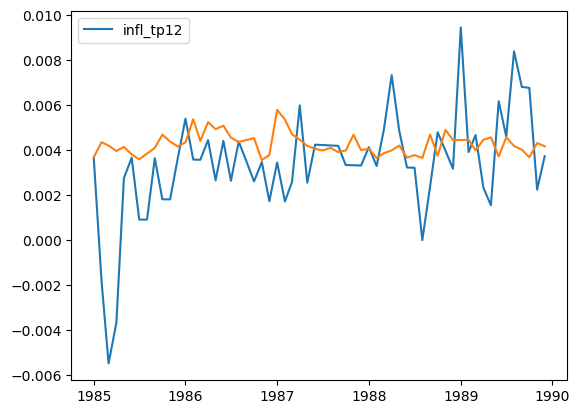

Validation RMSE, MAE, and OOS R2:[0.0025791239378912213, 0.0018081309750688766, 0.23484867413910682]


In [36]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, max_features='sqrt', random_state=1)
rf.fit(X_train, y_train)

plot_training_and_validation_pred(rf, X_train, X_val, y_train, y_val)

Ensembling the best LSTM (32-8d) results in huge gains with OOS R2 as high as 0.37!: Training RMSE, MAE, and R2:[0.0006043570839789187, 0.00046525754778696076, 0.9653489081780361]; Validation RMSE, MAE, and OOS R2:[0.0023344747236594466, 0.001739798943303085, 0.37312454950413354]

In [37]:
models = []
n_estimators=10
for i in range(n_estimators):
    print(f'Now training estimator {i+1} of {n_estimators}')
    cbs = [
        keras.callbacks.EarlyStopping(monitor='val_mae',min_delta=10**(-5), patience=200, restore_best_weights=True, verbose=1)
        # keras.callbacks.ReduceLROnPlateau(monitor='val_mae',min_delta=10**(-5), patience=250, restore_best_weights=True, verbose=1)
    ]
    lstm3 = keras.models.Sequential()
    # lstm3.add(keras.layers.LSTM(32, input_shape=input_shape, return_sequences=True))
    # lstm3.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    lstm3.add(keras.layers.LSTM(32, input_shape=input_shape))
    lstm3.add(keras.layers.Dense(8))
    # lstm3.add(keras.layers.Dense(4))
    lstm3.add(keras.layers.Dense(1))
    # optimizer = keras.optimizers.Nadam(learning_rate=0.1/3)
    lstm3.compile(loss='mse', optimizer='adam', metrics=['mae'])

    lstm3.fit(X_train_lstm, y_train,
              validation_data=(X_val_lstm, y_val),
              epochs=1500,
              batch_size=4,
              verbose=0,
              callbacks=cbs
    )
    models.append(lstm3)

model_input = keras.Input(shape=input_shape)
model_outputs = [model(model_input) for model in models]
ensemble_output = keras.layers.Average()(model_outputs)
lstm_ensemble = keras.Model(inputs=model_input, outputs=ensemble_output)

Now training estimator 1 of 10
Restoring model weights from the end of the best epoch: 367.
Epoch 567: early stopping
Now training estimator 2 of 10
Restoring model weights from the end of the best epoch: 313.
Epoch 513: early stopping
Now training estimator 3 of 10
Restoring model weights from the end of the best epoch: 415.
Epoch 615: early stopping
Now training estimator 4 of 10
Restoring model weights from the end of the best epoch: 604.
Epoch 804: early stopping
Now training estimator 5 of 10
Restoring model weights from the end of the best epoch: 391.
Epoch 591: early stopping
Now training estimator 6 of 10
Restoring model weights from the end of the best epoch: 344.
Epoch 544: early stopping
Now training estimator 7 of 10
Restoring model weights from the end of the best epoch: 771.
Epoch 971: early stopping
Now training estimator 8 of 10
Restoring model weights from the end of the best epoch: 355.
Epoch 555: early stopping
Now training estimator 9 of 10
Restoring model weights f

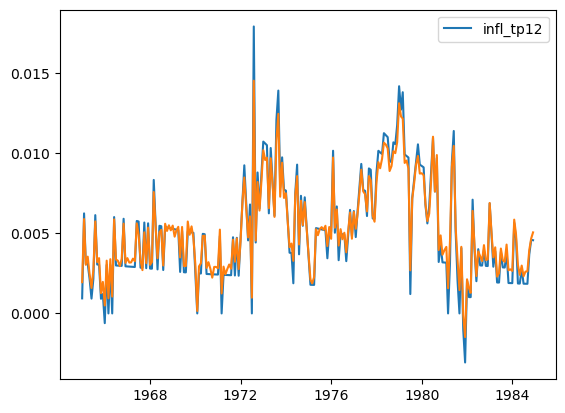

Training RMSE, MAE, and R2:[0.0006043570839789187, 0.00046525754778696076, 0.9653489081780361]


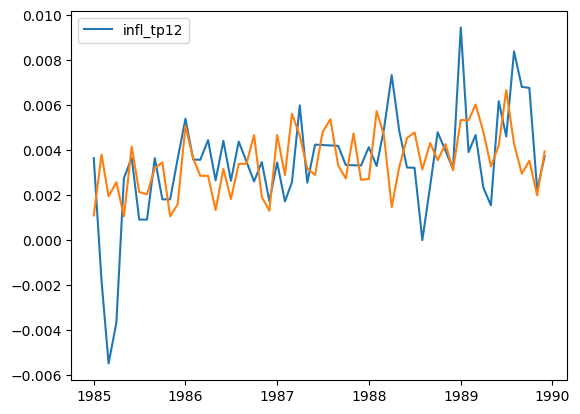

Validation RMSE, MAE, and OOS R2:[0.0023344747236594466, 0.001739798943303085, 0.37312454950413354]


In [38]:
plot_training_and_validation_pred(lstm_ensemble, X_train_lstm, X_val_lstm, y_train, y_val)

# Multitasking

In [76]:
def build_multitask_lstm(hardsharing_architecture, taskspecific_architecture, dense_architecture, ntasks, tasknames, input_shape, recurrent_dropout=0.0, l1=0.0):

    """
    Builds a multitask LSTM.

    Parameters
    ----------
    hardsharing_architecture: the architecture for the hardsharing layers (iterable).
    taskspecific_architectures: the architecture for each task specific group of layers (iterable of iterables).
    dense_architecture: the architecture for the additional dense layers added after LSTM layers and before output.
        If no dense layers are desired, set to None.
    ntasks: The number of tasks.
    tasknames: tasknames
    input_shape: input shape
    """

    inlayer = keras.layers.Input(shape=input_shape, name='input')

    # Create hardsharing layers
    hardsharing_layers = [ LSTM(nodes, return_sequences=True, recurrent_dropout=recurrent_dropout) for nodes in hardsharing_architecture  ]    

    hardsharing = keras.models.Sequential(hardsharing_layers)(inlayer)

    # Task-specific layers

    # Init output list. Each task has its own output
    outputs = []
    for i in range(ntasks):

        # Create task-specific layer. Return sequence unless last LSTM layer which feeds dense layer.
        tasklayers = [ LSTM(nodes, return_sequences=True, recurrent_dropout=recurrent_dropout) for nodes in taskspecific_architecture[:-1]]
        tasklayers.append(LSTM(taskspecific_architecture[-1], recurrent_dropout=recurrent_dropout))
        
        # Add dense layers if any
        if dense_architecture != None:
            for nodes in dense_architecture:
                tasklayers.append(Dense(nodes, activation='relu', kernel_regularizer=L1(l1=l1)))
        
        # Add output layer
        tasklayers.append(Dense(1, activation='linear'))

        # Create task-specific net
        tasknet = keras.models.Sequential(tasklayers, name=tasknames[i])(hardsharing)

        # Append task-specific net to outputs list
        outputs.append(tasknet)

    # Create and compile full model
    model = keras.models.Model(inputs=inlayer, outputs=outputs)
    
    model.compile(loss=['mse']*ntasks, optimizer='adam', metrics = ['mae'])

    return model



In [41]:
def multitask_preds_to_df(mtpreds, colnames):

    """
    Converts the output of a multi-task net to a dataframe of predictions.
    The output of the network is a list of arrays. Each array represents the
    predictions for a particular task given X_test.

    Parameters
    ----------
    mtpreds: output of the mt net (list).
    colnames: the column names of the y dataframe, i.e., the target names.

    Returns
    -------
    mtpreds_df: a dataframe where each column is the predictions for a particular target.
    """


    # Convert each preds array to series. Reshape necessary bec data must be 1D
    mtpreds = [pd.Series(pred.reshape((-1,))) for pred in mtpreds]

    # Concat all series in mtpreds list
    mtpreds_df = pd.concat(mtpreds, axis=1)

    # name columns
    mtpreds_df.columns = colnames

    return mtpreds_df


In [39]:
# all_targets = pd.read_csv('inflfc_targets.csv',index_col='date')
# all_targets.index = pd.to_datetime(all_targets.index)
# all_targets_train = all_targets.loc[y_train.index]
# all_targets_val = all_targets.loc[y_val.index]
# all_targets_test = all_targets.loc[y_test.index]
# mt_y_train_allh = [all_targets_train[col].values for col in all_targets_train]
# mt_y_val_allh = [all_targets_val[col].values for col in all_targets_val]
# mt_y_test_allh = [all_targets_test[col].values for col in all_targets_test]

In [311]:
unrate = pd.read_csv('delta_unrate.csv', index_col='date')
unrate.index = pd.to_datetime(unrate.index)
unrate = unrate['unrate_tp12'].to_frame()
unrate_train = unrate.loc[y_train.index]
unrate_val = unrate.loc[y_val.index]
unrate_test = unrate.loc[y_test.index]

mt_y_train = pd.concat([y_train, unrate_train],axis=1)
mt_y_val = pd.concat([y_val, unrate_val],axis=1)
mt_y_test = pd.concat([y_test, unrate_test],axis=1)

mt_y_train = [mt_y_train[col].values for col in mt_y_train]
mt_y_val = [mt_y_val[col].values for col in mt_y_val]
mt_y_test = [mt_y_test[col].values for col in mt_y_test]

In [305]:
hwi = pd.read_csv('delta_hwi.csv', index_col='date')
hwi.index = pd.to_datetime(hwi.index)
hwi = hwi['delta_hwi_tp12'].to_frame()
hwi_train = hwi.loc[y_train.index]
hwi_val = hwi.loc[y_val.index]
hwi_test = hwi.loc[y_test.index]

mt_y_train = pd.concat([y_train, hwi_train],axis=1)
mt_y_val = pd.concat([y_val, hwi_val],axis=1)
mt_y_test = pd.concat([y_test, hwi_test],axis=1)

mt_y_train = [mt_y_train[col].values for col in mt_y_train]
mt_y_val = [mt_y_val[col].values for col in mt_y_val]
mt_y_test = [mt_y_test[col].values for col in mt_y_test]

In [277]:
# vol = pd.read_csv('infl_volatility.csv', index_col='date')
# vol.index = pd.to_datetime(vol.index)
# vol_train = vol.loc[y_train.index]
# vol_val = vol.loc[y_val.index]
# vol_test = vol.loc[y_test.index]

# mt_y_train = pd.concat([y_train, vol_train],axis=1)
# mt_y_val =  pd.concat([y_val, vol_val],axis=1)

# mt_y_train = [mt_y_train[col].values for col in mt_y_train]
# mt_y_val = [mt_y_val[col].values for col in mt_y_val]

32---16 acheived good performance on some horizons (R2 > 0.30) while terrbile on others (R2 < -0.40). results on varying time horizons are highly variable. 

Adding early stopping made performance much worse consistently. Predictions were more variable. 

Forecasting inflation with log change in unemployment rate:

(32-32---8d-4d) Does okay. Seems to overfit as training R2 is 0.99 but validation R2 is quite low. 
- Adding early stopping is an improvement. Val R2 goes up to 0.19

Adding capacity to (32x3---8d-4d) results in slight improvement in both training and validation performance. Val R2 0.20

Added capacity to (32x3---8d-4d-2d) resulted in improvement in validation performnace, R2 of 0.3 but training performance decreased (early stopping stopped at epoch 3)
- A second run results in val R2 of only 0.04

Multitasking inflation with unemployment with 32x2---8x2-4d is great with oos r2 of 0.4


32-32---16-8d: Validation RMSE, MAE, and OOS R2:[0.0026433712831781123, 0.0019350550597877774, 0.19625322058156303] Training r2 ~ 0.97-0.99

32-32-32---16-8d: Training RMSE, MAE, and R2:[0.0022, 0.0017, 0.5226]; Validation RMSE, MAE, and OOS R2:[0.0026, 0.002, 0.2026]

32---16-8d: Training RMSE, MAE, and R2:[0.001, 0.0007, 0.9101]; Validation RMSE, MAE, and OOS R2:[0.0027, 0.0021, 0.1877]

16-16---16-8d: Training RMSE, MAE, and R2:[0.0022, 0.0017, 0.5367]; Validation RMSE, MAE, and OOS R2:[0.0026, 0.002, 0.2106]

32-32---8d: Training RMSE, MAE, and R2:[0.0008, 0.0006, 0.939]; Validation RMSE, MAE, and OOS R2:[0.0032, 0.0023, -0.1677]

32-32---8-8d: Training RMSE, MAE, and R2:[0.0006, 0.0005, 0.9692]; Validation RMSE, MAE, and OOS R2:[0.0028, 0.0021, 0.072]

32-32---8-8-8d: Training RMSE, MAE, and R2:[0.0024, 0.0019, 0.4699]; Validation RMSE, MAE, and OOS R2:[0.0025, 0.0018, 0.2748]

32-32---16-8d: Training RMSE, MAE, and R2:[0.0029, 0.0023, 0.2138]; Validation RMSE, MAE, and OOS R2:[0.0025, 0.0019, 0.2674]

32-32---4-4d: Training RMSE, MAE, and R2:[0.0011, 0.0009, 0.8778]; Validation RMSE, MAE, and OOS R2:[0.0029, 0.0022, 0.0404]

32---4-4d:Training RMSE, MAE, and R2:[0.0004, 0.0004, 0.9818]; Validation RMSE, MAE, and OOS R2:[0.0026, 0.0019, 0.2241]

16---4-4d: Training RMSE, MAE, and R2:[0.0006, 0.0005, 0.961]; Validation RMSE, MAE, and OOS R2:[0.0029, 0.0023, 0.0361]

8---4-4d: Training RMSE, MAE, and R2:[0.0005, 0.0004, 0.9784]; Validation RMSE, MAE, and OOS R2:[0.0029, 0.0021, 0.0445]

8-8---4-4d: bad

32-32---4-4d: Training RMSE, MAE, and R2:[0.0007, 0.0006, 0.952]; Validation RMSE, MAE, and OOS R2:[0.0024, 0.0017, 0.3438] dec min_delta to 10^-7

32-32---4-4-4d: Training RMSE, MAE, and R2:[0.0018, 0.0014, 0.6881]; Validation RMSE, MAE, and OOS R2:[0.0025, 0.0018, 0.2539] 

32-32---8-4d:Training RMSE, MAE, and R2:[0.001, 0.0008, 0.9093]; Validation RMSE, MAE, and OOS R2:[0.0025, 0.0019, 0.2866]

32---8-8d: Training RMSE, MAE, and R2:[0.0003, 0.0002, 0.994]; Validation RMSE, MAE, and OOS R2:[0.0024, 0.0017, 0.3603]

32---8-4d: Training RMSE, MAE, and R2:[0.0008, 0.0006, 0.9439]; Validation RMSE, MAE, and OOS R2:[0.0024, 0.0016, 0.3433] 
- Training appears more stable than above

In [440]:
{'a':1}.keys()

dict_keys(['a'])

In [437]:
to_monitor='val_loss'
# to_monitor= 'val_' + target + '_mae'
# to_monitor= 'val_' + 'unrate_tp12' + '_mae'
mt_early_stopping_monitor = keras.callbacks.EarlyStopping(monitor=to_monitor, min_delta=10**-7, patience=150, verbose=1, restore_best_weights=True)

mt_lstm1 = build_multitask_lstm(
    hardsharing_architecture=[32]*1,
    taskspecific_architecture=[16]*1,
    dense_architecture=[4],
    ntasks=len(mt_y_train),
    tasknames=[target, 'unrate'],
    input_shape=X_train_lstm.shape[1:],
    tasklayer_type='lstm'
)

hist = mt_lstm1.fit(
    X_train_lstm, mt_y_train, 
    validation_data = (X_val_lstm, mt_y_val),
    epochs=1000,
    batch_size=4,
    verbose=1,
    callbacks=[mt_early_stopping_monitor]
)

Epoch 1/1000
60/60 [==============================] - 14s 57ms/step - loss: 0.0039 - infl_tp12_loss: 0.0016 - unrate_loss: 0.0022 - infl_tp12_mae: 0.0307 - unrate_mae: 0.0360 - val_loss: 0.0019 - val_infl_tp12_loss: 8.1088e-04 - val_unrate_loss: 0.0011 - val_infl_tp12_mae: 0.0222 - val_unrate_mae: 0.0253
Epoch 2/1000
60/60 [==============================] - 0s 6ms/step - loss: 5.8725e-04 - infl_tp12_loss: 2.8466e-04 - unrate_loss: 3.0260e-04 - infl_tp12_mae: 0.0130 - unrate_mae: 0.0132 - val_loss: 9.0990e-04 - val_infl_tp12_loss: 3.8740e-04 - val_unrate_loss: 5.2250e-04 - val_infl_tp12_mae: 0.0160 - val_unrate_mae: 0.0176
Epoch 3/1000
60/60 [==============================] - 0s 5ms/step - loss: 2.2718e-04 - infl_tp12_loss: 1.1848e-04 - unrate_loss: 1.0870e-04 - infl_tp12_mae: 0.0087 - unrate_mae: 0.0082 - val_loss: 6.8306e-04 - val_infl_tp12_loss: 2.7364e-04 - val_unrate_loss: 4.0942e-04 - val_infl_tp12_mae: 0.0136 - val_unrate_mae: 0.0154
Epoch 4/1000
60/60 [==========================

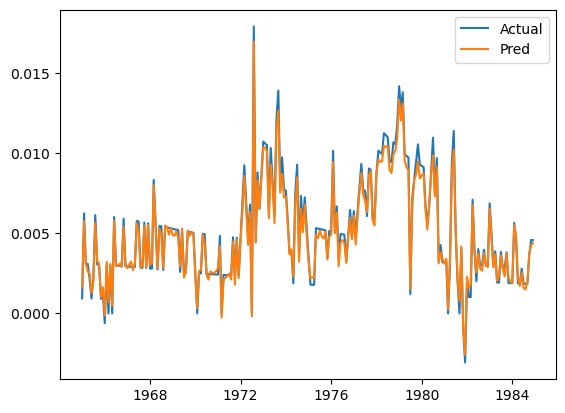

Training RMSE, MAE, and R2:[0.0004, 0.0003, 0.9832]


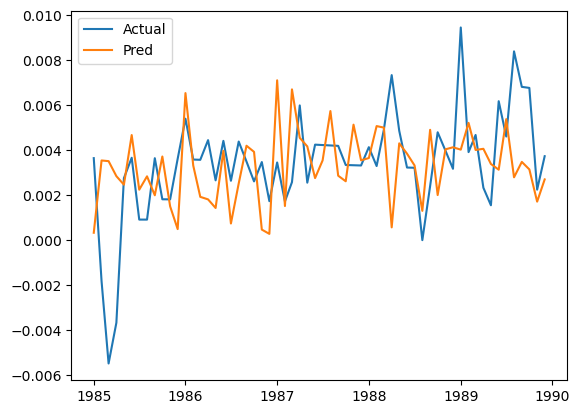

Validation RMSE, MAE, and OOS R2:[0.0027, 0.002, 0.1636]


In [438]:
task='infl_tp12'

mtlstm_train_pred = multitask_preds_to_df(mt_lstm1.predict(X_train_lstm), colnames=[target, 'unrate_tp12'])
mtlstm_val_pred = multitask_preds_to_df(mt_lstm1.predict(X_val_lstm), colnames=[target, 'unrate_tp12'])

mt_y_train_df = multitask_preds_to_df(mt_y_train, colnames=[target, 'unrate_tp12'])
mt_y_train_df.index = y_train.index
mt_y_val_df = multitask_preds_to_df(mt_y_val, colnames=[target, 'unrate_tp12'])
mt_y_val_df.index = y_val.index

plot_training_and_validation_pred(
    mt_lstm1,
    X_train_lstm,
    X_val_lstm,
    mt_y_train_df[task],
    mt_y_val_df[task],
    train_preds=mtlstm_train_pred[task].values.reshape(-1,),
    val_preds=mtlstm_val_pred[task].values.reshape(-1,),
    use_preds=True
)

<AxesSubplot: >

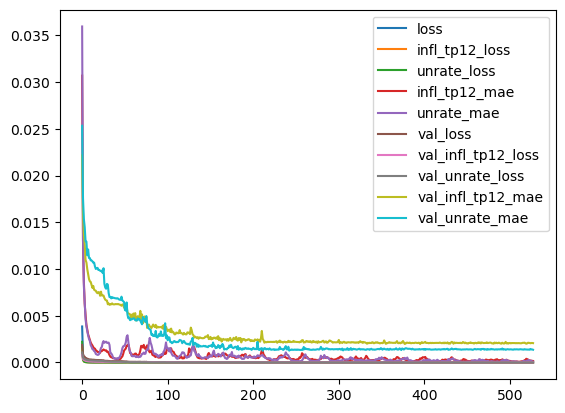

In [439]:
pd.DataFrame(hist.history).plot()